# Running the gerrychain to find a map without holes on congressional districts

@authors: vcle, bpuhani

In [1]:
import io
from contextlib import redirect_stdout

import maup
import pandas as pd

import utilities as util
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from gerrychain import Graph, Partition, proposals, updaters, constraints, accept, MarkovChain, Election
from gerrychain.tree import bipartition_tree
from gerrychain.updaters import cut_edges, Tally
from gerrychain.proposals import recom, propose_random_flip
from gerrychain.accept import always_accept
from functools import partial

## Loading the needed data.
For this notebook to work we assume, that you ran the following notebooks first:
* `0_IL_import_and_explore_data.ipynb`
* `B_2_IL_clean_maup_with_congress.ipynb`

In [2]:
il_df: gpd.GeoDataFrame = util.load_shapefile("il_data/IL_congress.shp")
il_graph: Graph = util.load_graph("il_data/IL_congress.shp")

Loading shapefile from il_data/IL_congress.shp...
Shapefile data loaded from cache.
Loading shapefile graph from il_data/IL_congress.shp...
Shapefile data loaded from cache.


In [3]:
# Set up the hole counter

def calculate_nr_of_holes(partition: Partition) -> int:
    """Calculates the number of holes in the partition"""

    districts_with_issues = {}

    for district, nodes in partition.parts.items():
        records = [partition.graph.nodes[n] for n in nodes]
        district_df = gpd.GeoDataFrame(records)

        buf = io.StringIO()

        try:
            with redirect_stdout(buf):
                try:
                    success = maup.doctor(district_df)
                except Exception as e:
                    print(f"Exception: {e}")
                    success = False
        finally:
            output = buf.getvalue().strip().replace("\n", " | ")
            buf.close()

        if not success:
            districts_with_issues[district] = output or "Unknown error"

    print("Districts with issues:", districts_with_issues)

    # Extract the number of holes for each district
    holes_per_district = {
        district: int(message.split()[2]) for district, message in districts_with_issues.items()
    }

    return sum(holes_per_district.values())

In [4]:
# Set up the initial partition object
initial_partition = Partition(
    il_graph,
    assignment="CONGD",  # as per assignment
    updaters={
        # setup updaters, that get updated per run of the chain
        "total_population": Tally("TOTPOP", alias="total_population"),
        "nr_of_holes": calculate_nr_of_holes,
        "cut_edges": cut_edges
    }
)

In [5]:
# Define the ideal population
ideal_population = sum(initial_partition["total_population"].values()) / len(initial_partition)
print("Nr of districts:", len(initial_partition))
print("Ideal population:", ideal_population)

Nr of districts: 17
Ideal population: 753676.9411764706


In [6]:
# Define the recom proposal
proposal = partial(
    recom,
    pop_col="TOTPOP",
    pop_target=ideal_population,
    epsilon=0.02,
    method=partial(
        bipartition_tree,
        max_attempts=100,
        allow_pair_reselection=True
    )
)

In [7]:
def run_the_chain(nr_of_total_steps: int, start_partition: Partition, offset: int = 0) -> Partition:
    """Runs the chain for the specified number of steps. Returns the last partition"""

    # Set up the chain
    chain = MarkovChain(
        proposal=proposal,
        constraints=[
            # Compactness constraint
            constraints.UpperBound(lambda p: len(p["cut_edges"]), 2 * len(initial_partition["cut_edges"])),
            # Population constraint
            constraints.within_percent_of_ideal_population(initial_partition, 0.02, "total_population")
        ],
        accept=always_accept,
        initial_state=start_partition,
        total_steps=nr_of_total_steps
    )
    last_partition: Partition = start_partition

    for (i, partition) in enumerate(chain.with_progress_bar()):
        last_partition = partition

        if i % 100 == 0 and i != 0:
            print("Overall holes:", partition.nr_of_holes)
            if partition.nr_of_holes == 0:
                break


        #print(f"There are {partition.nr_of_holes} holes overall")
        # append the number of cut edges for this proposal to the list



    return last_partition

In [8]:
partition_at_10_000 = run_the_chain(10_000, initial_partition)

  0%|          | 0/10000 [00:00<?, ?it/s]

Districts with issues: {15: 'There are 1 holes.', 16: 'There are 1 holes.', 2: 'There are 1 holes.'}
Overall holes: 3
Districts with issues: {}
Overall holes: 0


Verify the result:
(This result is not reproducible)

In [44]:
districts_df: gpd.GeoDataFrame = gpd.GeoDataFrame()


for district, nodes in partition_at_10_000.parts.items():
        records = [partition_at_10_000.graph.nodes[n] for n in nodes]
        this_district_df = gpd.GeoDataFrame(records)
        this_district_df["district"] = district
        districts_df = gpd.GeoDataFrame(pd.concat([districts_df, this_district_df], ignore_index=True))



In [37]:
print(len(districts_df))
print(len(il_df))

10083
10083


In [38]:
print(f"{sum(il_df['TOTPOP']):_}")  # check if there are any holes

12_812_508


In [39]:
print(f"{sum(districts_df['TOTPOP']):_}")  # check if there are any holes

12_812_508


In [41]:
print(set(districts_df["district"]))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}


In [42]:
maup.doctor(districts_df[districts_df["district"] == 11])

There are 22 holes.


False

In [2]:
districts_df = util.load_shapefile("il_data/IL_congress_without_holes.shp")

Loading shapefile from il_data/IL_congress_without_holes.shp...
Shapefile data loaded from cache.


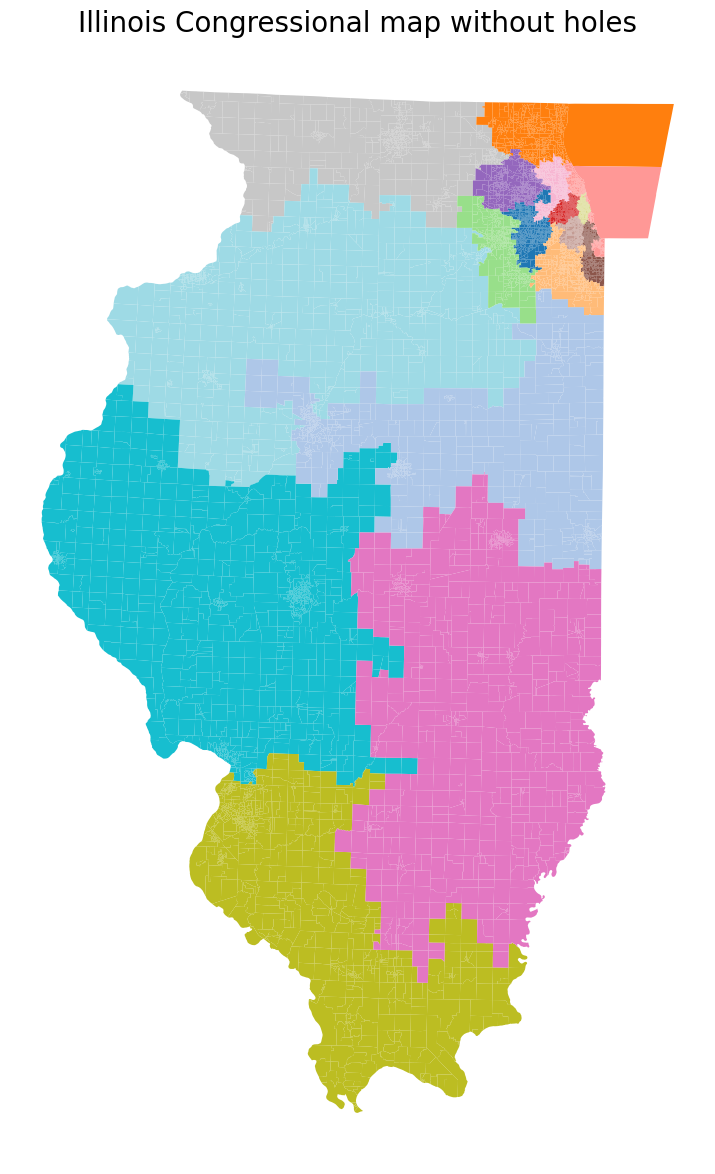

In [3]:
# Plot map
title = "Illinois Congressional map without holes"
districts_df.plot(column="district", cmap="tab20", figsize=(12, 12), legend=False)

# Final touches
plt.axis("off")
plt.title(title, fontsize=20)
plt.tight_layout()
plt.savefig(f"images/illinois_map_{title}.svg", bbox_inches="tight")
plt.show()
plt.close()

In [52]:
districts_df.head()

,boundary_node,area,STATEFP20,COUNTYFP20,VTDST20,GEOID20,NAME20,G20PRED,G20PRER,G20USSD,...,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,CONGD,geometry,boundary_perim,district
0,False,4.442025e+07,17,089,00HA01,1708900HA01,HAMPSHIRE 1,533,951,496,...,45,4,30,2,5,42,11,"POLYGON ((372914.611 4667983.615, 373152.151 4...",NaN,13
1,False,1.595962e+07,17,089,00HA03,1708900HA03,HAMPSHIRE 3,817,1075,784,...,27,0,53,0,7,53,11,"POLYGON ((377488.509 4661270.769, 378270.827 4...",NaN,13
2,False,1.689435e+06,17,037,00DK09,1703700DK09,DEKALB 9,716,346,691,...,145,0,142,0,2,70,14,"POLYGON ((353634.734 4645132.022, 353637.142 4...",NaN,13
3,False,9.126377e+06,17,037,00DK02,1703700DK02,DEKALB 2,677,133,604,...,1313,5,292,1,20,141,14,"POLYGON ((353009.650 4644432.345, 353008.190 4...",NaN,13
4,False,8.399433e+07,17,201,00Bu01,1720100Bu01,Burritt 1,187,432,183,...,11,0,4,0,4,27,16,"MULTIPOLYGON (((320348.357 4685411.822, 320348...",NaN,13


In [55]:
# set the crf to the same as the original dataframe
districts_df.crs = il_df.crs

In [56]:
# save the map to a shapefile
districts_df.to_file("il_data/IL_congress_without_holes.shp")

C:\Users\benni\AppData\Local\Temp\ipykernel_27748\2437023331.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  districts_df.to_file("il_data/IL_congress_without_holes.shp")


In [57]:
# load to make sure it worked
saved_df = util.load_shapefile("il_data/IL_congress_without_holes.shp")
saved_df_graph = util.load_graph("il_data/IL_congress_without_holes.shp")

Loading shapefile from il_data/IL_congress_without_holes.shp...
Loading shapefile...
Shapefile data saved successfully to il_data/IL_congress_without_holes.shp.pkl.
Loading shapefile graph from il_data/IL_congress_without_holes.shp...
Loading shapefile...


C:\Users\benni\workspace\6-Semester\ai-for-redistricting\venv\Lib\site-packages\gerrychain\graph\graph.py:457: UserWarning: NA values found in column boundary_p!
  warnings.warn("NA values found in column {}!".format(column))


Shapefile data saved successfully to il_data/IL_congress_without_holes.shp.graph.pkl.


In [59]:
saved_df.head()

,boundary_n,area,STATEFP20,COUNTYFP20,VTDST20,GEOID20,NAME20,G20PRED,G20PRER,G20USSD,...,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,CONGD,boundary_p,district,geometry
0,False,4.442025e+07,17,089,00HA01,1708900HA01,HAMPSHIRE 1,533,951,496,...,45,4,30,2,5,42,11,NaN,13,"POLYGON ((372914.611 4667983.615, 373152.151 4..."
1,False,1.595962e+07,17,089,00HA03,1708900HA03,HAMPSHIRE 3,817,1075,784,...,27,0,53,0,7,53,11,NaN,13,"POLYGON ((377488.509 4661270.769, 378270.827 4..."
2,False,1.689435e+06,17,037,00DK09,1703700DK09,DEKALB 9,716,346,691,...,145,0,142,0,2,70,14,NaN,13,"POLYGON ((353634.734 4645132.022, 353637.142 4..."
3,False,9.126377e+06,17,037,00DK02,1703700DK02,DEKALB 2,677,133,604,...,1313,5,292,1,20,141,14,NaN,13,"POLYGON ((353009.650 4644432.345, 353008.190 4..."
4,False,8.399433e+07,17,201,00Bu01,1720100Bu01,Burritt 1,187,432,183,...,11,0,4,0,4,27,16,NaN,13,"MULTIPOLYGON (((320348.357 4685411.822, 320348..."
